# Validation Tools
Tools for validating BIM objects

Currently the validation of BIM models before they are delivered to the client takes a significant amount of time. Using different sections an experienced modeler tries to validate each BIM element with the point cloud as background. To speed up this process this tools provides a per BIM element analysis between the BIM geometry and the point cloud data.



First the geomapi and external packages are imported

In [1]:
import os
import open3d as o3d
import time
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
#IMPORT MODULES
from context import geomapi
import geomapi.utils as ut
import geomapi.tools as tl
from geomapi.nodes import *
import geomapi.tools.validationtools as vt

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

## Preprocessing the BIM Model

Following the GEOMAPI principles, we serialize all relevent objects in the BIM model to an RDF Graph.

In [5]:
ifcPath = os.path.join(Path(os.getcwd()).parents[2],'test','testfiles','IFC','steel_structure.ifc')
BIMNodes = []

For this analysis, we parse the ifc files using all CPU's.

In [6]:
BIMNodes.extend(tl.ifc_to_nodes_multiprocessing(ifcPath = ifcPath, getResource = True))

Next code block visualizes all elements within the BIM Model that were succesfully converted into GEOMAPI BIMNodes containing a geometry.
It is not uncommon for certain elements to not have geometry or have some invalid meshes. These will yield **Geometry Production Errors** and are not stored in a GEOMAPI BIMNode because we only retrieve those elments containing a geometry.

![image](../../pics/BIM.PNG)

***figure 1:*** BIM model

In [ ]:
#Now we can visualize the BIM data
# o3d.visualization.draw_geometries([BIMNode.resource for BIMNode in BIMNodes])

For this analysis we zere only interested in the structural elemens such as beams and columns (But the provided code will work accordingly for other classes like walls). The model looks very clean on first sigth but when we color the elements corresponding to the classes we want, it can be seen that also other elements are present in the model. Those elements, colored in red are not needed for the analysis because after inspection there can be concluded that those elments exisit of connection between steel elements, anckers for the concrete, bolts and screws,... 

![image](../../pics/BIMclasses.PNG)

***figure 2:*** BIM model classified as IfcBeams (green), IfcColumns (orange) and clutter (red)

In [7]:
for BIMNode in BIMNodes:
    if BIMNode.className == 'IfcBeam':
        BIMNode.resource.paint_uniform_color([0.788,1.0,0.0])
    elif BIMNode.className == 'IfcColumn':
        BIMNode.resource.paint_uniform_color([1.0,0.753,0.0])
    else:
        BIMNode.resource.paint_uniform_color([1.0,0.0,0.0])

# o3d.visualization.draw_geometries([BIMNode.resource for BIMNode in BIMNodes])

Those elements are mostly very small or are not visible in the scanning data. Therfore these elements will be removed from the BIMNodes list and ignored for further analysis. This reduces the number of BIMNodes to be processed from 301 to 173

In [8]:
print("Before class filtering: %s BIMNodes" % len(BIMNodes))
i=0
while i < len(BIMNodes):
    BIMNode = BIMNodes[i]
    BIMNode.name = BIMNode.className + BIMNode.globalId
    if BIMNode.className == 'IfcBeam' or BIMNode.className == 'IfcColumn':
        i += 1
    else:
        BIMNodes.pop(i)
print("After class filtering: %s BIMNodes" % len(BIMNodes))

Before class filtering: 301 BIMNodes
After class filtering: 173 BIMNodes


To be able to make computations between the BIM geometry and the captured point cloud all BIM geometries are sampled to a point cloud. To this end the GEOMAPI theoretical visibility functions are used. This allows us to achieve better results where unvisible point mostly influnce the analysisi results by matching with clutter objects.

In [9]:

#First the resolution of the sampling is determined
resolution = 0.01

#Then the visibility pointCloud is created for every BIMNode and stored in meshPCD variable that is added to the BIMNode
referencepcds =[]
referenceids = []
visibility = []

BIMpcdNodes = []

for BIMNode in BIMNodes:
    BIMNode.linkedNodes = []
    meshPCD, theoreticalVisibility = geomapi.utils.geometryutils.create_visible_point_cloud_from_meshes(
                                                            geometries=BIMNode.resource,
                                                            references=[bm.resource for bm in BIMNodes if bm is not BIMNode],
                                                            resolution=resolution,
                                                            getNormals= True)
    BIMNode.theoreticalVisibility = theoreticalVisibility[0]
    
    if theoreticalVisibility[0] > 0.1:
        referencepcds.append(meshPCD[0])
        referenceids.append(BIMNode.subject)
        visibility.append((BIMNode.subject, theoreticalVisibility[0]))
        BIMpcdNode = geomapi.nodes.PointCloudNode(subject = BIMNode.subject, name = BIMNode.name, resource = meshPCD[0])
        BIMpcdNodes.append(BIMpcdNode)

In [10]:
referenceSession = geomapi.nodes.SessionNode(name = "reference_session",linkedNodes= BIMNodes)
#Why not?? Session moet een convex hull hebben als resource kan geen folder zijn
# referenceSession.path = os.path.join(Path(os.getcwd()).parents[2],'tests','Samples14','myAnalysisFolder',referenceSession.name)

referenceSession_path = os.path.join(Path(os.getcwd()).parents[2],'test','testfiles','SESSION',referenceSession.name)
if not os.path.exists(referenceSession_path):
    os.mkdir(referenceSession_path)


In [11]:
for BIMNode in BIMNodes:
    # Make sure the BIM elemnts have a unique name before saving them
    BIMNode.name = BIMNode.className + BIMNode.globalId + str(time.time_ns())
    # Save all BIMNode resources (meshes) to disk to save memory.
    BIMNode.save_resource(os.path.join(referenceSession_path,'MESHES'))
    del BIMNode.resource
BIMgraphPath=os.path.join(referenceSession_path,'bimGraph.ttl')
geomapi.tl.nodes_to_graph(nodelist=BIMNodes,graphPath=BIMgraphPath,save=True)

for BIMpcdNode in BIMpcdNodes:
    #Make sure the BIM elemnts have a unique name before saving them
    BIMpcdNode.name = BIMpcdNode.name + str(time.time_ns())
    #Save all BIMNode resources (meshes) to disk to save memory.
    BIMpcdNode.save_resource(os.path.join(referenceSession_path,'PCDS'))
BIMpcdgraphPath=os.path.join(referenceSession_path,'bimPcdGraph.ttl')
geomapi.tl.nodes_to_graph(nodelist=BIMpcdNodes,graphPath=BIMpcdgraphPath,save=True)


<Graph identifier=N781e70a9757f4d67aa4361bdcda60114 (<class 'rdflib.graph.Graph'>)>

## Pointcloud processing
Now the reference object are processed and the captured data will be processed. This data is not reference data and can change, for example during the construction phase where sequential measurement campaigns are organised. Therefore, the reults of these analysis are stored separetly in a SessionNode containing all BIMnodes from above.

In [12]:
pcdPath = os.path.join(Path(os.getcwd()).parents[2],'test','testfiles','PCD','pointcloud2sub.e57')
pcdNodes=tl.e57header_to_nodes(pcdPath)

Create a session conteining all the data that can change, such as the captured data and the analysis

In [13]:
session = geomapi.nodes.SessionNode(name = "session_" + time.strftime("%Y%m%d-%H%M%S"), linkedNodes = pcdNodes + BIMNodes + BIMpcdNodes)

sessionFolder=os.path.join(Path(os.getcwd()).parents[2],'test','testfiles','SESSION',session.name)
if not os.path.exists(sessionFolder):
    os.mkdir(sessionFolder)

graphPath=os.path.join(sessionFolder,'SessionGraph.ttl')
tl.nodes_to_graph(nodelist=pcdNodes,graphPath=graphPath,save=True)

<Graph identifier=N6cd6364d43d34bf68d90e597ff453f08 (<class 'rdflib.graph.Graph'>)>

Because we don't have any information about the pointclouds such as their boundingboxes, the pointclouds must be loaded to determine these parameters

In [14]:
for pcdNode in pcdNodes:
    pcdNode.get_resource() 
pcd = [pcdNode.resource for pcdNode in pcdNodes]

## LOA comparison
The next function will determines yo which element each point of the point cloud belongs + the distance between these points. By doing this matching the LOA percentages will be more accurate, ignore more clutter.

In [17]:
joinedPCD, identityArray, distances = vt.match_BIM_points(sources = pcd, references = referencepcds, referenceIds= referenceids)

The next function determines the percentage of inliers per LOA bracket

In [18]:
LOA = vt.compute_LOA(identityArray, distances, byElement=True)

## Result visualization
Next we will demonstrate the different options to visualize the analysis results. This can be done by element or for the entire project at once

## Histograms per element
![image](../../pics/perelementhist.PNG)

***figure 3:*** Histogram illustrating the cistances between the source point and the matched reference point

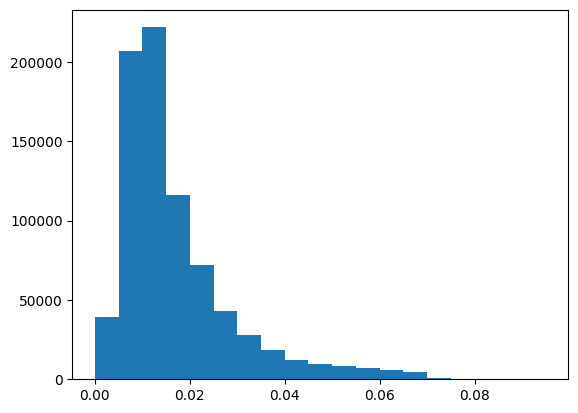

In [19]:
vt.plot_histogram(identityArray, distances, directory = sessionFolder, byElement= True, show = False)
vt.plot_histogram(identityArray, distances)

## Pointclouds
![image](../../pics/ColoredPCD.PNG)

***figure 4:*** Pointcloud where the points are colored by LOA

In [20]:
coloredPCD = vt.color_point_cloud_by_LOA(joinedPCD, identityArray, distances)
# o3d.visualization.draw_geometries(coloredPCD)
o3d.io.write_point_cloud(os.path.join(sessionFolder, 'CompleteColoredresult' + '.pcd'), coloredPCD)

True

![image](../../pics/GradientPCD.PNG)

***figure 4:*** Pointcloud where the points are colored by their distance

In [21]:
gradientPCD = vt.color_point_cloud_by_distance(joinedPCD, identityArray, distances)
# o3d.visualization.draw_geometries(coloredPCD)
o3d.io.write_point_cloud(os.path.join(sessionFolder, 'CompleteGradientresult' + '.pcd'), gradientPCD)

True

## Data files
![image](../../pics/csv.PNG)

***figure 5:*** A csv file with the analysis results

In [22]:
vt.csv_by_LOA(sessionFolder, LOA, visibility=visibility)

True

![image](../../pics/excel.PNG)

***figure 6:*** Excel file with the analysis results

In [23]:
vt.excel_by_LOA(sessionFolder, LOA, visibility=visibility)

True

## Meshes
![image](../../pics/ColoredMesh.PNG)

***figure 7:*** Mesh colored according to the LOA level of the element

In [24]:
vt.color_BIMNode(LOA, BIMNodes)
geometries = [BIMNode.resource for BIMNode in BIMNodes]
for BIMNode in BIMNodes:
    BIMNode.save_resource(directory = os.path.join(sessionFolder, "meshes"))
# o3d.visualization.draw_geometries(geometries)